## Import Libraries

In [3]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (precision_score, recall_score, f1_score, fbeta_score,
                             confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve, make_scorer)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier

import joblib

In [4]:
loanDF = pd.read_csv('../../datasets/Loan_Default_cleaned_downsampled.csv')
loanDF_full = pd.read_csv('../../datasets/Loan_Default_cleaned_all.csv')
loanDF_raw = pd.read_csv('../../datasets/Loan_Default.csv')

## Splitting Data

In [5]:
X = loanDF.drop('status', axis=1)
y = loanDF.status
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
feature_names = loanDF.columns

Utility Functions

In [17]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # annotations to include values and corresponding labels
    labels = [["{} (TN)".format(cm[0, 0]), "{} (FP)".format(cm[0, 1])], 
            ["{} (FN)".format(cm[1, 0]), "{} (TP)".format(cm[1, 1])]]

    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', 
                xticklabels=['Not Granted', 'Loan Granted'], 
                yticklabels=['Not Granted', 'Loan Granted'])

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix using {type(model).__name__}')
    plt.savefig(f'../../plots/plots-phase2/Confusion Matrix using {type(model).__name__}.png')
    plt.show()


def ROCcurve(X_test, y_test, models, plot_name=None):
    # plt.figure(figsize=(10, 8))
    if not isinstance(models, list):
        models = [models]   
    for model in models:
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        plt.plot(fpr, tpr, label=f'{type(model).__name__} (AUC = {auc(fpr, tpr):.2f})')
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='r')
    
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    if plot_name is None:
        plot_name = type(model).__name__
    plt.savefig(f'../../plots/plots-phase2/ROC Curve Comparison {plot_name}.png')
    
    plt.show()

## Algorithms/Visualizations

In [7]:
# Custom scroring to choose parametrics that optimize precison and recall.
# Choosing beta < 1 to give importance to precision over recall
fbeta_scorer = make_scorer(fbeta_score, beta=0.7)

### (1) Logistic Regression

In [8]:
lr_model = LogisticRegression(solver='lbfgs', max_iter=1000)

In [9]:
# Train the model
lr_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred_lr = lr_model.predict(X_test)

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.72      0.89      0.80      6867
         1.0       0.86      0.67      0.75      7051

    accuracy                           0.78     13918
   macro avg       0.79      0.78      0.77     13918
weighted avg       0.79      0.78      0.77     13918



Consider macro avg, since this is a binary classification problem.

Overall accuracy: 78%

Precision and Recall are 79% and 78% respectively


Feature Importance:
credit_type_CRIF: 8.426056846347205
occupancy_type_sr: 1.4507664246473286
region_south: 1.4507664246473286
construction_type_sb: 1.206508975324662
loan_type_type3: 1.1703385428448996
business_or_commercial_nob/c: 0.941961138796019
co_applicant_credit_type_EXP: 0.8619415025108237
credit_worthiness_l2: 0.8434517376096753
approv_in_adv_pre: 0.8214508276925658
loan_type_type2: 0.6617989346503419


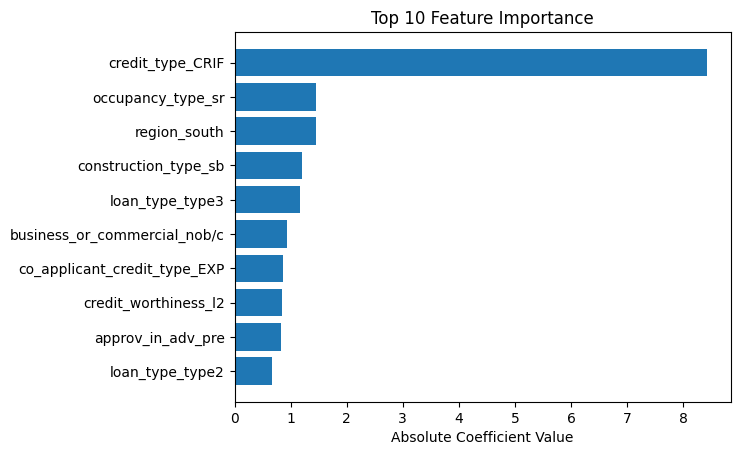

In [10]:
coefficients = lr_model.coef_[0]
# Feature Importance
feature_importance = {feature: abs(coef) for feature, coef in zip(feature_names, coefficients)}
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

print("\nFeature Importance:")
for feature, importance in sorted_importance[:10]:
    print(f"{feature}: {importance}")

top_feature_names, top_importances = zip(*sorted_importance[:10])  

plt.barh(top_feature_names, top_importances)
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()  # Ensure the most important feature is at the top
plt.show()



According to definition, credit_type is the company that gave the credit report of a customer. Let's analyze why that is an important feature.

### Re-training the model without credit_type column

In [11]:
new_loan_df = loanDF.drop([col for col in loanDF.columns if col.startswith('credit_type')], axis=1)
X_ = new_loan_df.drop('status', axis=1)
y_ = new_loan_df.status
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.2, random_state=42)

lr_model_ = LogisticRegression(solver='lbfgs', max_iter=2000)

# Train the model
lr_model_.fit(X_train_, y_train_)

# Predict the labels for the test set
y_pred_lr_ = lr_model_.predict(X_test_)

print(classification_report(y_test_, y_pred_lr_))


              precision    recall  f1-score   support

         0.0       0.66      0.73      0.69      6867
         1.0       0.71      0.64      0.67      7051

    accuracy                           0.68     13918
   macro avg       0.68      0.68      0.68     13918
weighted avg       0.69      0.68      0.68     13918



### Feature Importance 

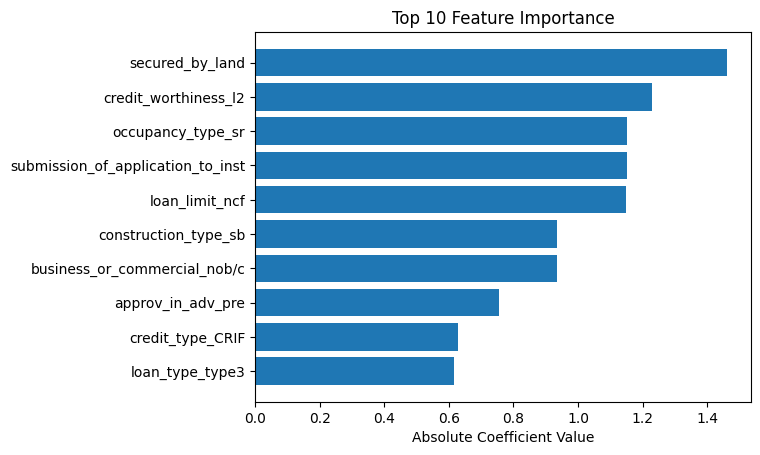

In [12]:
coefficients = lr_model_.coef_[0]
# Feature Importance
feature_importance = {feature: abs(coef) for feature, coef in zip(feature_names, coefficients)}
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)


top_feature_names, top_importances = zip(*sorted_importance[:10])  

plt.barh(top_feature_names, top_importances)
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()  # Ensure the most important feature is at the top
plt.show()

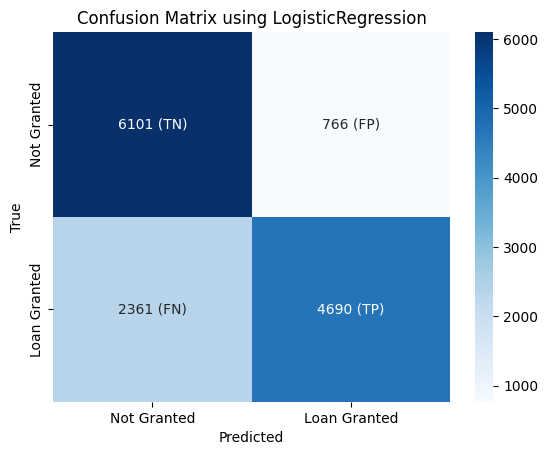

In [13]:
plot_confusion_matrix(X_test, y_test, lr_model)

The new model trained without credit_type information acheived low score. Indicating that credit_type column is infact helping the model. Moreover, the features that have high importance like secured_by_land, credit_worthiness and occupancy_type are good general indicators. So, this model generalizes better.

In addition, the old model has less False Positive Rate(FPR), indicating that it will help us in avoiding potential loan defaulters.

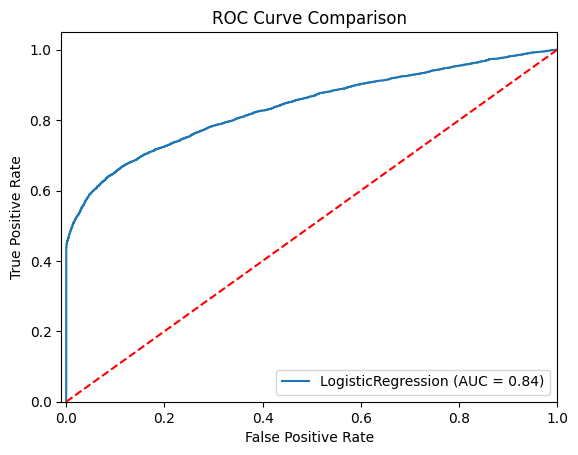

In [14]:
ROCcurve( X_test, y_test, lr_model, 'Logistic Regression')

### (2) k-NN

In [15]:
# Train KNN model
knn = KNeighborsClassifier(n_neighbors=3)

In [16]:

knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

         0.0       0.96      0.88      0.91      6867
         1.0       0.89      0.96      0.92      7051

    accuracy                           0.92     13918
   macro avg       0.92      0.92      0.92     13918
weighted avg       0.92      0.92      0.92     13918



##### Performing cross validation to find the best performing k value. Using `fbeta_scorer`

In [17]:
# This code requires alot of time, so commented it.
if False:
    avg_scores = []

    for k in tqdm(range(1,20)):
        _knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(_knn, X, y, cv=10, scoring=fbeta_scorer, n_jobs=-1)  # 10-fold cross-validation
        avg_scores.append(np.mean(scores))

    # Find the k with the highest average score
    optimal_k = avg_scores.index(max(avg_scores))+1
    print("Optimal value of k:", optimal_k)


In [18]:
# Obtained as a result of above code.
avg_scores = [0.9051399102776465, 0.9185438306976881, 0.9164576115002457, 0.9277381755577144, 0.9184907968342781, 0.9291681715875478, 0.9196190570628708, 0.9278961550649333, 0.9202192562029274, 0.9273556344972504, 0.919676901607876, 0.9258715171168316, 0.9192816588560044, 0.9247694753378072, 0.9181984487805124, 0.923587411699959, 0.9172783610944937, 0.922685763550394, 0.9164517623996222]
optimal_k = 6

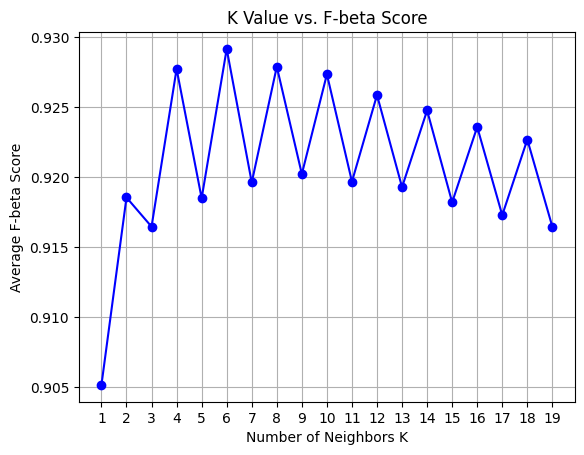

In [19]:
# Plotting
plt.plot(range(1, 20), avg_scores, marker='o', linestyle='-', color='b')
plt.title('K Value vs. F-beta Score')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Average F-beta Score')
plt.xticks(range(1, 20))
plt.grid(True)
plt.show()

In [20]:
# Train KNN model
knn_best = KNeighborsClassifier(n_neighbors=optimal_k)
knn_best.fit(X_train, y_train)
y_pred_knn = knn_best.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93      6867
         1.0       0.91      0.95      0.93      7051

    accuracy                           0.93     13918
   macro avg       0.93      0.93      0.93     13918
weighted avg       0.93      0.93      0.93     13918



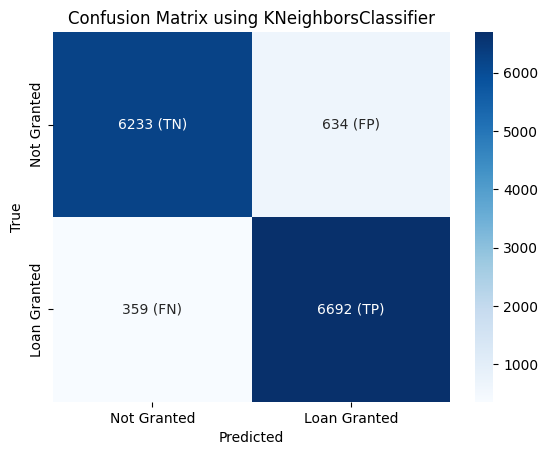

In [21]:
plot_confusion_matrix(X_test, y_test, knn_best)

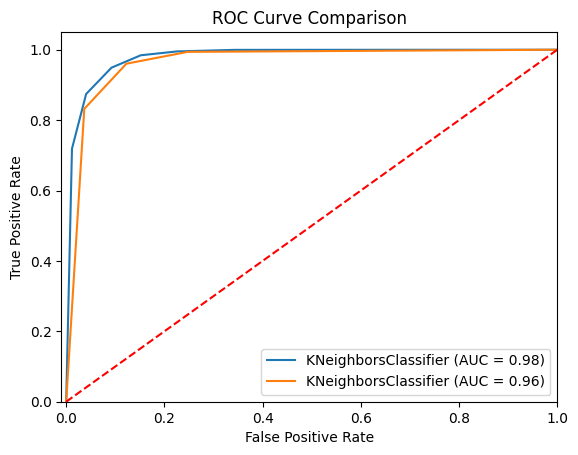

In [22]:
ROCcurve(X_test, y_test, [knn_best, knn], "Comparing KNN")

### (3) Naive Bayes

In [23]:
nb_model = GaussianNB()

In [24]:

# Train the model
nb_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred_nb = nb_model.predict(X_test)
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

         0.0       0.68      1.00      0.81      6867
         1.0       1.00      0.54      0.70      7051

    accuracy                           0.77     13918
   macro avg       0.84      0.77      0.75     13918
weighted avg       0.84      0.77      0.75     13918



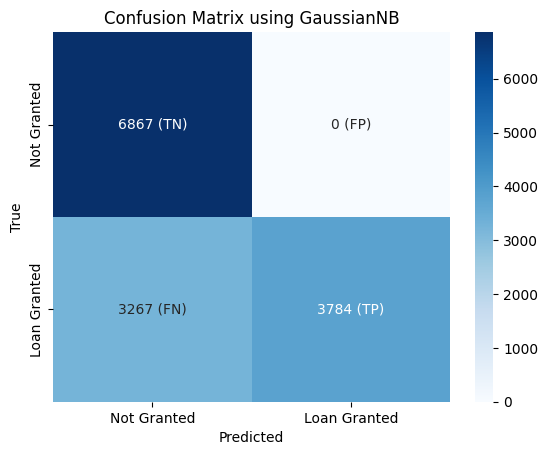

In [25]:
plot_confusion_matrix(X_test, y_test, nb_model)

### (4) SVM(Support vector machines)

In [26]:
# Initialize
svm_model = SVC()

In [27]:
svm_model_file = '../models/svm_model.joblib'

if not os.path.exists(svm_model_file):
    svm_model.fit(X_train, y_train)
    
    y_pred_svm = svm_model.predict(X_test)
    
    # Save the trained model to reuse later without retraining
    joblib.dump(svm_model, svm_model_file)
else:
    print("Loading pre-trained model")
    svm_model = joblib.load(svm_model_file)

    # Predict using the loaded SVM model
    y_pred_svm = svm_model.predict(X_test)


Loading pre-trained model


In [28]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

         0.0       0.65      0.97      0.78      6867
         1.0       0.94      0.50      0.65      7051

    accuracy                           0.73     13918
   macro avg       0.80      0.73      0.72     13918
weighted avg       0.80      0.73      0.72     13918



In [29]:
# Print the parameters after training
# print("Support vectors:\n", svm_model.support_vectors_)
print("Indices of support vectors:", svm_model.support_)
print("Number of support vectors for each class:", svm_model.n_support_)
print("Coefficients of the support vector in the decision function:", svm_model.dual_coef_)
if svm_model.kernel == 'linear':
    print("Weights assigned to the features (coef_):", svm_model.coef_)
print("Constants in decision function (intercept_):", svm_model.intercept_)

Indices of support vectors: [    0     4    21 ... 55660 55662 55663]
Number of support vectors for each class: [20428 20412]
Coefficients of the support vector in the decision function: [[-1. -1. -1. ...  1.  1.  1.]]
Constants in decision function (intercept_): [-3.19271449]


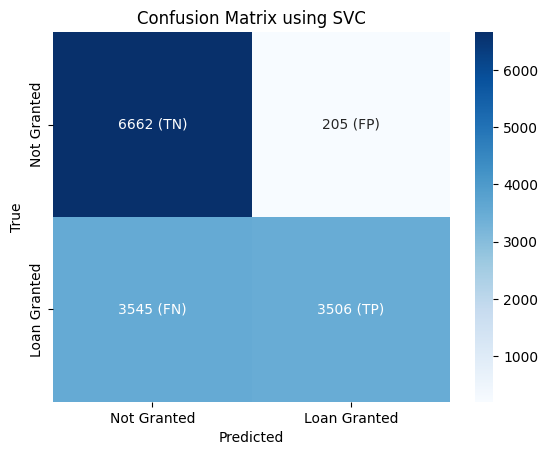

In [30]:
plot_confusion_matrix(X_test, y_test, svm_model)

### (5) decision tree

In [12]:
# Initialize Decision Tree classifier
dt_model = DecisionTreeClassifier()

# Train the model
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [13]:
# Predict the labels for the test set
y_pred_dt = dt_model.predict(X_test)

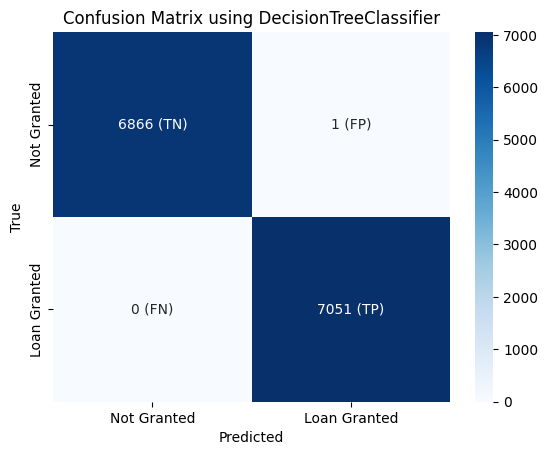

In [18]:
plot_confusion_matrix(X_test, y_test, dt_model)

In [19]:
decision_tree = '../../models/decision_tree.pkl'
joblib.dump(dt_model, decision_tree)

['../../models/decision_tree.pkl']

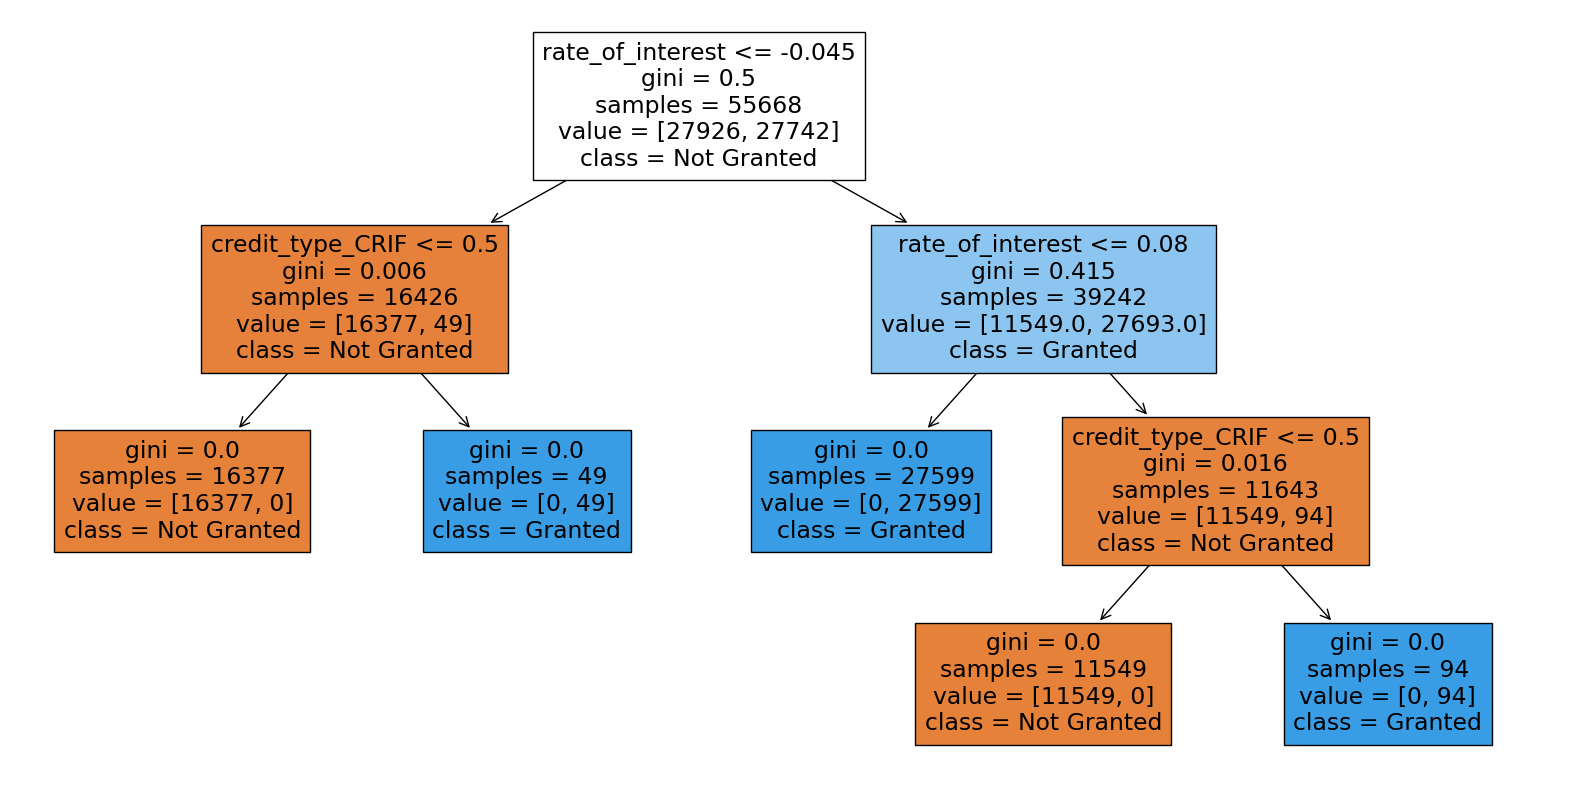

In [34]:
from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(dt_model, filled=True, feature_names=feature_names, class_names=['Not Granted', 'Granted'])

# Save the plot as an image file
plt.savefig('../../plots/plots-phase2/decision_tree.png')

plt.show()


### (6) random forest

In [35]:
rf_model = RandomForestClassifier(n_estimators=3, random_state=1)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=3, random_state=1)

In [36]:
# Predict the labels for the test set
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6867
         1.0       1.00      1.00      1.00      7051

    accuracy                           1.00     13918
   macro avg       1.00      1.00      1.00     13918
weighted avg       1.00      1.00      1.00     13918



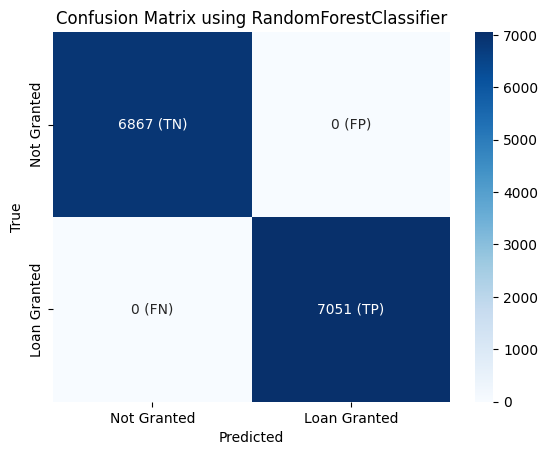

In [37]:
plot_confusion_matrix(X_test, y_test, rf_model)

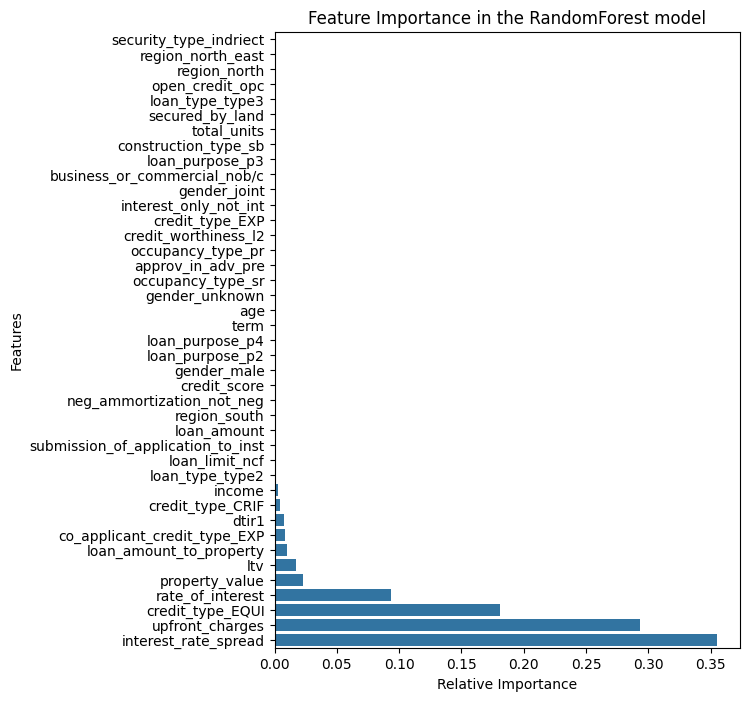

In [38]:
rf_feature_importance = rf_model.feature_importances_
rf_sorted_idx = rf_feature_importance.argsort()

plt.figure(figsize=(6,8))
sns.barplot(x=rf_feature_importance[rf_sorted_idx], y=X_train.columns[rf_sorted_idx])
plt.title('Feature Importance in the RandomForest model')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

### (7) XGBoost

In [39]:
# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [40]:
# Predict the labels for the test set
y_pred_xgb = xgb_model.predict(X_test)

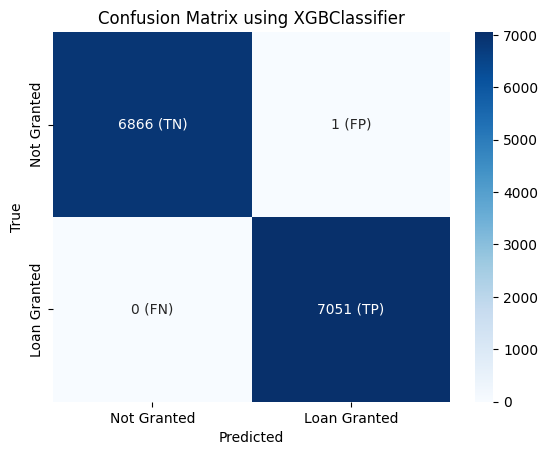

In [41]:
plot_confusion_matrix(X_test, y_test, xgb_model)

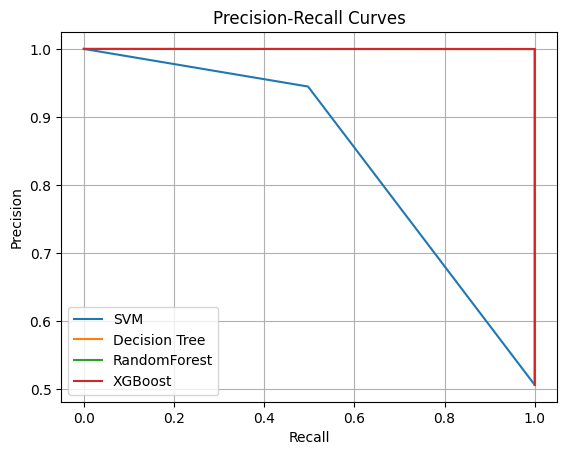

In [42]:
# precision and recall for SVM, Decision Tree and XGBoost
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_pred_svm)
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_pred_dt) 
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_xgb)

# Plotting precision-recall curves
plt.plot(recall_svm, precision_svm, label='SVM')
plt.plot(recall_dt, precision_dt, label='Decision Tree')
plt.plot(recall_rf, precision_rf, label='RandomForest')
plt.plot(recall_xgb, precision_xgb, label='XGBoost')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.show()

## Select the best model

In [51]:
# Define the models
models = {
    "Logistic Regression": lr_model, 
    "KNN": knn_best,
    "Naive Bayes": nb_model,
     # commented as it takes more than 2+hrs to run svm. Moreover, it is not among the best models. 
    # "SVM": svm_model,
    "Decision Tree": dt_model, 
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
}

# Create pipelines for each model
pipelines = {name: Pipeline([ ('model', model)]) for name, model in models.items()}

In [52]:
# Evaluate each model using cross-validation
cv_scores = {}
for name, pipeline in tqdm(pipelines.items(), desc='Evaluating models'):
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=fbeta_scorer, n_jobs=-1).mean()
    cv_scores[name] = score

# Print the performance
for model in cv_scores:
    print(f"{model}: {cv_scores[model]}")

# Select the best model based on CV score
best_model_name = max(cv_scores, key=cv_scores.get)
best_model = pipelines[best_model_name]

Evaluating models:   0%|          | 0/6 [00:00<?, ?it/s]

Logistic Regression: 0.7762186472581092
KNN: 0.9257482647717816
Naive Bayes: 0.7772287164884575
Decision Tree: 1.0
Random Forest: 1.0
XGBoost: 1.0


In [54]:
print(cv_scores)

{'Logistic Regression': 0.7762186472581092, 'KNN': 0.9257482647717816, 'Naive Bayes': 0.7772287164884575, 'Decision Tree': 1.0, 'Random Forest': 1.0, 'XGBoost': 1.0}


In [55]:
best_model

Pipeline(steps=[('model', DecisionTreeClassifier())])

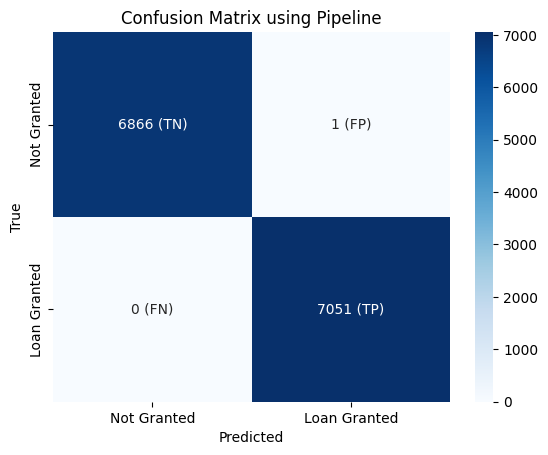

In [56]:
plot_confusion_matrix(X_test, y_test, best_model)

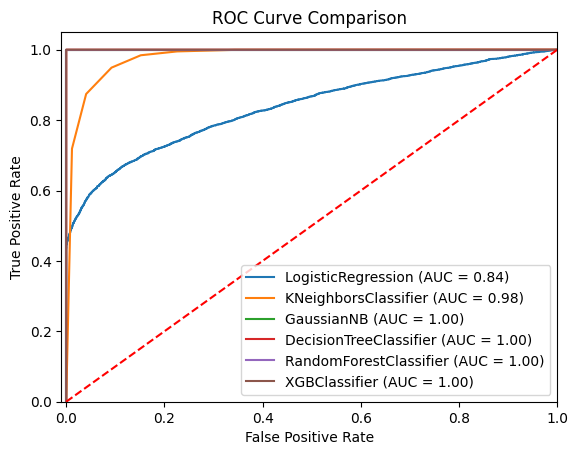

In [57]:
ROCcurve(X_test, y_test, list(models.values()), "All Models")

## References

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

https://xgboost.readthedocs.io/en/stable/